# COMP34212 Summative Lab Hyperparameter Values Evaluation
## Resnet Architecture on CIFAR-10 Dataset

# Imports

In [6]:
#import the necessary libraries
from math import sqrt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
#The following imports are used for Bayesian Optimization
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import GridSearchCV
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
import numpy as np
import random

# The seed value
seed_value = 42

# Set the seed for the random number generators
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)

# Set the deterministic algorithms for CuDNN
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetch Data (Load CIFAR 10 and apply data augementation)

In [8]:
def fetch_data():
    # Load the CIFAR-10 dataset and apply data augmentation
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ])

    # Load the CIFAR-10 dataset
    train_set = datasets.CIFAR10(root='./dataset', train=True, download=True, transform=transform_train)
    test_set = datasets.CIFAR10(root='./dataset', train=False, download=True, transform=transform_test)

    # Split train set into train and validation sets
    train_size = int(0.8 * len(train_set))
    val_size = len(train_set) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(train_set, [train_size, val_size])

    # Create data loaders for train, validation, and test sets
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True)
    test_data_loader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

    return train_data_loader, val_data_loader, test_data_loader


# DEFINE RESNET Architecture

In [9]:
# Define the ResNet architecture
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear1 = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride, kernel_size=3):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, kernel_size))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear1(out)
        return out

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, kernel_size=3):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=kernel_size, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

# DEFINE UTILITY FUNCTIONS

In [10]:
def train(model, optimizer, criterion, trainloader):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        train_total += targets.size(0)
        train_correct += predicted.eq(targets).sum().item()

    train_accuracy = 100. * train_correct / train_total
    train_loss /= len(trainloader)
    print('Training - Loss: {:.4f}, Accuracy: {:.4f}%'.format(train_loss, train_accuracy))

    return train_loss, train_accuracy


def evaluate(model, criterion, testloader, scheduler=None):
    """ArithmeticError
    Evaluate the model on the test set
    
    Returns:
    test_loss: float
    test_accuracy: float
    
    """

    model.eval()
    total = 0
    correct = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item() * labels.size(0)

    test_accuracy = 100 * correct / total
    test_loss /= len(testloader.dataset)
    
    print('Validation - Loss: {:.4f}, Accuracy: {:.4f}%'.format(test_loss , test_accuracy))
   
    return test_loss, test_accuracy


def train_and_validate(model, optimizer, criterion, trainloader, valloader, num_epochs):
    model.to(device)

    train_loss = 0.0
    train_accuracy=0.0
    
    val_total = 0
    val_accuracy=0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        
        train_loss,train_accuracy = train(model,optimizer,criterion,trainloader)
        val_loss,val_accuracy = evaluate(model,criterion,valloader)
        
    return train_loss, train_accuracy, val_loss, val_accuracy

def test(model,criterion,testloader):
    
    model.eval()
    total = 0
    correct = 0
    test_loss = 0.0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item() * labels.size(0)

    test_accuracy = 100 * correct / total
    test_loss /= len(testloader.dataset)
    
    print('Testing - Loss: {:.4f}, Accuracy: {:.4f}%'.format(test_loss , test_accuracy))

    return test_loss, test_accuracy


In [11]:
# Load the CIFAR-10 dataset 
trainloader,valloader,testloader = fetch_data()
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified
Files already downloaded and verified


In [12]:
import csv
import os

def write_to_csv(filename, data):
    # Check if file exists
    file_exists = os.path.isfile(filename)

    # Open the CSV file in append mode
    with open(filename, 'a', newline='') as file:
        writer = csv.writer(file)
        # Write the header only if the file didn't exist
        if not file_exists:
            writer.writerow(["lr", "beta1", "beta2", "weight_decay", "train_accuracy", "train_loss", "val_accuracy", "val_loss"])
        # Write the data
        writer.writerow(data)

# 

# Perform Bayesian Optimization with Adam

In [8]:
# Define the search space for the hyperparameters
search_space = [Real(1e-6, 1e+0, prior='log-uniform', name='lr'),
                Real(0.1, 0.999, name='beta1'),
                Real(0.1, 0.999, name='beta2'),
                Real(1e-6, 1e-3, prior='log-uniform', name='weight_decay')
                ]

n_epoch = 20

# Define the objective function for the Bayesian optimization
@use_named_args(search_space)
def objective_ADAM(lr, beta1, beta2, weight_decay):

    # Define the model
    model = ResNet(BasicBlock, [2, 1, 1, 1])

    print(f'\n Testing hyperparameters: lr={lr}, beta1={beta1}, beta2={beta2}, weight_decay={weight_decay}')


    # Define the optimizer with the given hyperparameters
    optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)

    # Train the model and return the validation accuracy
    train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model, optimizer, criterion, trainloader, valloader, n_epoch)

    # Write the hyperparameters and results to the CSV file
    write_to_csv('Adam_hyperparameters_results.csv', [lr, beta1, beta2, weight_decay, train_accuracies, train_losses, val_accuracies, val_losses])


    return -val_accuracies  # minimize negative accuracy

# Perform the Bayesian optimization
result = gp_minimize(objective_ADAM, search_space, n_calls=10, random_state=0)

# Print the best hyperparameters and the corresponding validation accuracy
print('Best hyperparameters:', result.x)
print('Best validation accuracy:', -result.fun)



 Testing hyperparameters: lr=0.0036063486397284665, beta1=0.8589949079743348, beta2=0.8712931102428585, weight_decay=0.0003481410351917474
Epoch 1/20
----------
Training - Loss: 1.7627, Accuracy: 33.3575%
Validation - Loss: 1.5796, Accuracy: 41.3000%
Epoch 2/20
----------
Training - Loss: 1.3450, Accuracy: 51.1575%
Validation - Loss: 1.2313, Accuracy: 55.6300%
Epoch 3/20
----------
Training - Loss: 1.1573, Accuracy: 58.5700%
Validation - Loss: 1.2001, Accuracy: 58.6300%
Epoch 4/20
----------
Training - Loss: 1.0638, Accuracy: 62.2525%
Validation - Loss: 1.3010, Accuracy: 55.0400%
Epoch 5/20
----------
Training - Loss: 1.0035, Accuracy: 64.5675%
Validation - Loss: 0.9262, Accuracy: 67.3600%
Epoch 6/20
----------
Training - Loss: 0.9492, Accuracy: 66.6100%
Validation - Loss: 0.9182, Accuracy: 66.9300%
Epoch 7/20
----------
Training - Loss: 0.9082, Accuracy: 68.4025%
Validation - Loss: 0.8962, Accuracy: 68.5700%
Epoch 8/20
----------
Training - Loss: 0.8663, Accuracy: 69.7725%
Validation

In [9]:
# Define the best hyperparameters found by Bayesian optimization
best_lr, best_beta1, best_beta2, best_weight_decay = result.x

# Define the model and dataset
model = ResNet(BasicBlock, [2, 1, 1, 1])
# summary(model.to(device), input_size=(3, 32, 32))
# Define the Adam optimizer with the best hyperparameters
optimizer = optim.Adam(model.parameters(), lr=best_lr, betas=(best_beta1, best_beta2), weight_decay=best_weight_decay)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=3)


# Train the model with the best hyperparameters and validate
train_and_validate(model,optimizer,criterion,trainloader,valloader, num_epochs=80)

Epoch 1/80
----------
Training - Loss: 1.3716, Accuracy: 49.9375%
Validation - Loss: 1.1468, Accuracy: 59.8800%
Epoch 2/80
----------
Training - Loss: 0.9453, Accuracy: 66.5700%
Validation - Loss: 0.8741, Accuracy: 68.7000%
Epoch 3/80
----------
Training - Loss: 0.7725, Accuracy: 72.9550%
Validation - Loss: 0.7260, Accuracy: 74.8100%
Epoch 4/80
----------
Training - Loss: 0.6634, Accuracy: 76.8825%
Validation - Loss: 0.6918, Accuracy: 76.1300%
Epoch 5/80
----------
Training - Loss: 0.6020, Accuracy: 79.1750%
Validation - Loss: 0.5828, Accuracy: 80.0200%
Epoch 6/80
----------
Training - Loss: 0.5484, Accuracy: 80.9700%
Validation - Loss: 0.5861, Accuracy: 79.7200%
Epoch 7/80
----------
Training - Loss: 0.5069, Accuracy: 82.2750%
Validation - Loss: 0.5955, Accuracy: 79.7800%
Epoch 8/80
----------
Training - Loss: 0.4687, Accuracy: 83.8475%
Validation - Loss: 0.4969, Accuracy: 82.5500%
Epoch 9/80
----------
Training - Loss: 0.4397, Accuracy: 84.8875%
Validation - Loss: 0.4835, Accuracy: 8

(0.09820909519456326, 96.6075, 0.3464723717659712, 90.33)

In [10]:
test(model,criterion,testloader)

Testing - Loss: 0.4275, Accuracy: 89.7100%


(0.42754303381964565, 89.71)

In [11]:
# #Best hyperparameters obtained from the Bayesian Optimization for ADAM for CIFAR-10 dataset 100 epochs
# Best_hyperparameters = [0.00016197546636104998, 0.9604824878987889, 0.22617535159096802, 0.0004076259041096254] 
# best_lr = Best_hyperparameters[0]
# best_beta1 = Best_hyperparameters[1]
# best_beta2 = Best_hyperparameters[2]
# best_weight_decay = Best_hyperparameters[3]

# # Define the search space for the hyperparameters
# search_space = [Real(1e-6, 1e+0, prior='log-uniform', name='lr'),
#                 # Real(0.1, 0.999, name='beta1'),
#                 # Real(0.1, 0.999, name='beta2'),
#                 # Real(1e-6, 1e-3, prior='log-uniform', name='weight_decay')
#                 ]

# n_epoch = 1

# # Define the objective function for the Bayesian optimization
# @use_named_args(search_space)
# def objective_ADAM(lr):
#     Best_hyperparameters = [0.00016197546636104998, 0.9604824878987889, 0.22617535159096802, 0.0004076259041096254] 
#     best_lr = Best_hyperparameters[0]
#     beta1 = Best_hyperparameters[1]
#     beta2 = Best_hyperparameters[2]
#     weight_decay = Best_hyperparameters[3]
#     # Define the model
#     model = ResNet(BasicBlock, [2, 1, 1, 1])

#     print(f'\n Testing hyperparameters: lr={lr}, beta1={beta1}, beta2={beta2}, weight_decay={weight_decay}')


#     # Define the optimizer with the given hyperparameters
#     optimizer = optim.Adam(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay)

#     # Train the model and return the validation accuracy
#     train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model, optimizer, criterion, trainloader, valloader, n_epoch)

#     # Write the hyperparameters and results to the CSV file
#     write_to_csv('Adam_hyperparameters_results.csv', [lr, beta1, beta2, weight_decay, train_accuracies, train_losses, val_accuracies, val_losses])


#     return -val_accuracies  # minimize negative accuracy

# # Perform the Bayesian optimization
# result = gp_minimize(objective_ADAM, search_space, n_calls=10, random_state=0)

# # Print the best hyperparameters and the corresponding validation accuracy
# print('Best hyperparameters:', result.x)
# print('Best validation accuracy:', -result.fun)


# Perform Bayesian Optimization with SGD

In [12]:
# Define the search space for the hyperparameters
search_space = [Real(1e-6, 0.4, prior='log-uniform', name='lr'),
                Real(0.1, 0.999, name='momentum'),
                Real(1e-6, 1e-3, prior='log-uniform', name='weight_decay')]

n_epoch = 20
# Define the objective function for the Bayesian optimization
@use_named_args(search_space)
def objective_SGD(lr, momentum, weight_decay):

    # Define the model
    model = ResNet(BasicBlock, [2, 1, 1, 1])

    print(f'\n Testing hyperparameters: lr={lr}, momentum={momentum}, weight_decay={weight_decay}')
    # Define the optimizer with the given hyperparameters
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=3)
    # Train the model and return the validation accuracy
    train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model, optimizer, criterion, trainloader, valloader, n_epoch)
    write_to_csv('SGD_hyperparameters_results.csv', [lr, momentum, weight_decay, train_accuracies, train_losses, val_accuracies, val_losses])


    return -val_accuracies  # minimize negative accuracy

# Perform the Bayesian optimization
result = gp_minimize(objective_SGD, search_space, n_calls=10, random_state=0)

# Print the best hyperparameters and the corresponding validation accuracy
print('Best hyperparameters:', result.x)
print('Best validation accuracy:', -result.fun)


 Testing hyperparameters: lr=0.0020948412486806525, momentum=0.8589949079743348, weight_decay=0.0003748321662847933
Epoch 1/20
----------
Training - Loss: 1.4957, Accuracy: 45.1500%
Validation - Loss: 1.2696, Accuracy: 53.6100%
Epoch 2/20
----------
Training - Loss: 1.0812, Accuracy: 60.9850%
Validation - Loss: 0.9729, Accuracy: 65.6400%
Epoch 3/20
----------
Training - Loss: 0.8961, Accuracy: 68.3250%
Validation - Loss: 0.9053, Accuracy: 67.8900%
Epoch 4/20
----------
Training - Loss: 0.7772, Accuracy: 72.7725%
Validation - Loss: 0.7805, Accuracy: 72.9600%
Epoch 5/20
----------
Training - Loss: 0.6877, Accuracy: 75.8550%
Validation - Loss: 0.7813, Accuracy: 73.2000%
Epoch 6/20
----------
Training - Loss: 0.6255, Accuracy: 78.1300%
Validation - Loss: 0.8079, Accuracy: 72.6000%
Epoch 7/20
----------
Training - Loss: 0.5674, Accuracy: 80.5125%
Validation - Loss: 0.6225, Accuracy: 78.7600%
Epoch 8/20
----------
Training - Loss: 0.5315, Accuracy: 81.5675%
Validation - Loss: 0.5723, Accura

In [13]:
# Define the best hyperparameters found by Bayesian optimization
best_lr, best_momentum, best_weight_decay = [0.0015078369731868298, 0.8516348084201026, 0.001028462547983764]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model and dataset
model = ResNet(BasicBlock, [2, 1, 1, 1])
# Define the SGD optimizer with the best hyperparameters
optimizer = optim.SGD(model.parameters(), lr=best_lr, momentum=best_momentum, weight_decay=best_weight_decay)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')
criterion = nn.CrossEntropyLoss()

# Train the model with the best hyperparameters and validate
train_and_validate(model,optimizer,criterion,trainloader,valloader,80)

Epoch 1/80
----------
Training - Loss: 1.5312, Accuracy: 43.7500%
Validation - Loss: 1.2874, Accuracy: 52.8200%
Epoch 2/80
----------
Training - Loss: 1.1218, Accuracy: 59.8725%
Validation - Loss: 1.1233, Accuracy: 59.7100%
Epoch 3/80
----------
Training - Loss: 0.9435, Accuracy: 66.6250%
Validation - Loss: 0.9818, Accuracy: 65.4000%
Epoch 4/80
----------
Training - Loss: 0.8170, Accuracy: 71.4325%
Validation - Loss: 0.7598, Accuracy: 72.9900%
Epoch 5/80
----------
Training - Loss: 0.7206, Accuracy: 74.7425%
Validation - Loss: 0.6958, Accuracy: 75.1300%
Epoch 6/80
----------
Training - Loss: 0.6573, Accuracy: 77.4950%
Validation - Loss: 0.6774, Accuracy: 76.6500%
Epoch 7/80
----------
Training - Loss: 0.6053, Accuracy: 79.2675%
Validation - Loss: 0.6321, Accuracy: 77.8700%
Epoch 8/80
----------
Training - Loss: 0.5678, Accuracy: 80.5075%
Validation - Loss: 0.5489, Accuracy: 80.8000%
Epoch 9/80
----------
Training - Loss: 0.5237, Accuracy: 82.0700%
Validation - Loss: 0.5504, Accuracy: 8

(0.07022274516839534, 97.8675, 0.3230345283806324, 90.14)

In [14]:
test(model,criterion,testloader)

Testing - Loss: 0.3531, Accuracy: 90.0600%


(0.3531437533438206, 90.06)

## Learning rate

In [15]:
# Define the best hyperparameters found by Bayesian optimization
Best_hyperparameters = [0.00016197546636104998, 0.9604824878987889, 0.22617535159096802, 0.0004076259041096254] 
best_lr = 0.1
best_beta1 = Best_hyperparameters[1]
best_beta2 = Best_hyperparameters[2]
best_weight_decay = Best_hyperparameters[3]

# Define the model and dataset
model = ResNet(BasicBlock, [2, 1, 1, 1])
# Define the Adam optimizer with the best hyperparameters
optimizer = optim.Adam(model.parameters(), lr=0.1, betas=(best_beta1, best_beta2), weight_decay=best_weight_decay)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience=3)


# Train the model with the best hyperparameters and validate
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model,optimizer,criterion,trainloader,valloader, num_epochs=50)
write_to_csv('Adam_01_results.csv', [best_lr, best_beta1, best_beta2, best_weight_decay, train_accuracies, train_losses, val_accuracies, val_losses])

Epoch 1/50
----------
Training - Loss: 3.7143, Accuracy: 14.8325%
Validation - Loss: 22.4112, Accuracy: 10.3500%
Epoch 2/50
----------
Training - Loss: 4.7664, Accuracy: 12.7700%
Validation - Loss: 53.8126, Accuracy: 10.0600%
Epoch 3/50
----------
Training - Loss: 6.2614, Accuracy: 11.5525%
Validation - Loss: 157.5184, Accuracy: 10.2500%
Epoch 4/50
----------
Training - Loss: 6.4728, Accuracy: 12.0900%
Validation - Loss: 24.4577, Accuracy: 10.3500%
Epoch 5/50
----------
Training - Loss: 3.5573, Accuracy: 14.1775%
Validation - Loss: 6.4790, Accuracy: 10.5700%
Epoch 6/50
----------
Training - Loss: 3.4251, Accuracy: 13.8750%
Validation - Loss: 6.6105, Accuracy: 10.6400%
Epoch 7/50
----------
Training - Loss: 3.9918, Accuracy: 13.6475%
Validation - Loss: 9.2879, Accuracy: 12.2900%
Epoch 8/50
----------
Training - Loss: 5.4971, Accuracy: 12.0775%
Validation - Loss: 28.2567, Accuracy: 9.9900%
Epoch 9/50
----------
Training - Loss: 5.1271, Accuracy: 13.1050%
Validation - Loss: 8.2577, Accura

In [16]:
best_lr = 0.01

optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(best_beta1, best_beta2), weight_decay=best_weight_decay)
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model,optimizer,criterion,trainloader,valloader, num_epochs=50)
write_to_csv('Adam_001_results.csv', [best_lr, best_beta1, best_beta2, best_weight_decay, train_accuracies, train_losses, val_accuracies, val_losses])

Epoch 1/50
----------
Training - Loss: 1.9240, Accuracy: 26.6825%
Validation - Loss: 1.7767, Accuracy: 32.3200%
Epoch 2/50
----------
Training - Loss: 1.6881, Accuracy: 36.4925%
Validation - Loss: 1.6747, Accuracy: 38.2400%
Epoch 3/50
----------
Training - Loss: 1.5748, Accuracy: 41.6725%
Validation - Loss: 1.8254, Accuracy: 35.7900%
Epoch 4/50
----------
Training - Loss: 1.5146, Accuracy: 44.4000%
Validation - Loss: 1.5774, Accuracy: 43.8700%
Epoch 5/50
----------
Training - Loss: 1.4517, Accuracy: 46.5850%
Validation - Loss: 1.7619, Accuracy: 37.7100%
Epoch 6/50
----------
Training - Loss: 1.4094, Accuracy: 48.5475%
Validation - Loss: 1.6830, Accuracy: 41.2600%
Epoch 7/50
----------
Training - Loss: 1.3642, Accuracy: 50.7075%
Validation - Loss: 1.7265, Accuracy: 42.1700%
Epoch 8/50
----------
Training - Loss: 1.3545, Accuracy: 51.1050%
Validation - Loss: 1.4008, Accuracy: 50.0900%
Epoch 9/50
----------
Training - Loss: 1.3464, Accuracy: 51.4875%
Validation - Loss: 1.3561, Accuracy: 5

In [17]:
best_lr = 0.001

optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(best_beta1, best_beta2), weight_decay=best_weight_decay)
train_losses, train_accuracies, val_losses, val_accuracies = train_and_validate(model,optimizer,criterion,trainloader,valloader, num_epochs=50)
write_to_csv('Adam_0001_results.csv', [best_lr, best_beta1, best_beta2, best_weight_decay, train_accuracies, train_losses, val_accuracies, val_losses])

Epoch 1/50
----------
Training - Loss: 1.0913, Accuracy: 61.1400%
Validation - Loss: 1.0063, Accuracy: 63.6900%
Epoch 2/50
----------
Training - Loss: 1.0343, Accuracy: 62.9500%
Validation - Loss: 1.0022, Accuracy: 64.7400%
Epoch 3/50
----------
Training - Loss: 0.9989, Accuracy: 64.5075%
Validation - Loss: 0.9505, Accuracy: 66.2500%
Epoch 4/50
----------
Training - Loss: 0.9624, Accuracy: 65.9150%
Validation - Loss: 0.9156, Accuracy: 67.0500%
Epoch 5/50
----------
Training - Loss: 0.9279, Accuracy: 67.0100%
Validation - Loss: 0.8767, Accuracy: 68.8800%
Epoch 6/50
----------
Training - Loss: 0.9030, Accuracy: 67.9000%
Validation - Loss: 0.8806, Accuracy: 68.4800%
Epoch 7/50
----------
Training - Loss: 0.8724, Accuracy: 69.2225%
Validation - Loss: 0.8469, Accuracy: 70.1700%
Epoch 8/50
----------
Training - Loss: 0.8416, Accuracy: 70.4400%
Validation - Loss: 0.8457, Accuracy: 69.9900%
Epoch 9/50
----------
Training - Loss: 0.8091, Accuracy: 71.6525%
Validation - Loss: 0.7965, Accuracy: 7

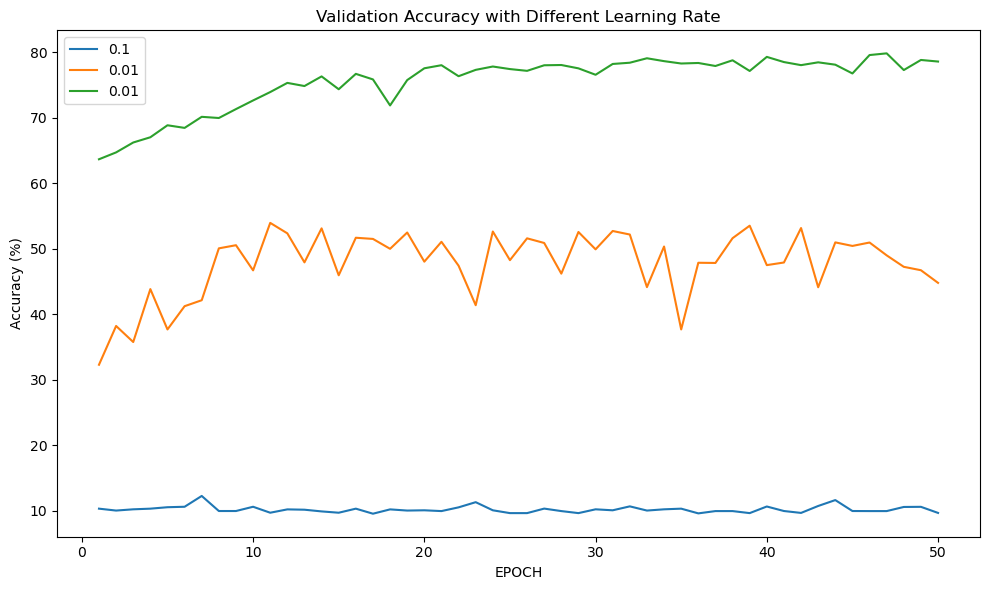

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the validation accuracy data from CSV files
file_paths = ["Adam_01_results.csv", "Adam_001_results.csv", "Adam_0001_results.csv"]  # Replace with your file paths
labels = ["0.1", "0.01", "0.01"]  # Labels for the legend

plt.figure(figsize=(10, 6))  # Set the figure size

# Plot validation accuracy from each file
for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    plt.plot(data['Epoch'], data['Validation Accuracy'], label=labels[i])
    # plt.plot(data['Epoch'], data['Validation Loss'], label=labels[i])

plt.xlabel('EPOCH')  # X-axis label
plt.ylabel('Accuracy (%)')  # Y-axis label
plt.title('Validation Accuracy with Different Learning Rate')  # Title of the plot
plt.legend()  # Show legend
plt.grid(False)  # Show grid
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()  # Show plot
